# Практическое задание №5. Атака с ограниченной памятью (PGD - Projected Gradient Descent)
## Выполнил студент группы ББМО-01-23 Агасиев Максим Артурович

### 1. Загрузка обученной модели и данных MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 0.0858
Test accuracy on clean images: 0.9772999882698059


### 2. Реализация атаки PGD с использованием Foolbox

In [3]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00


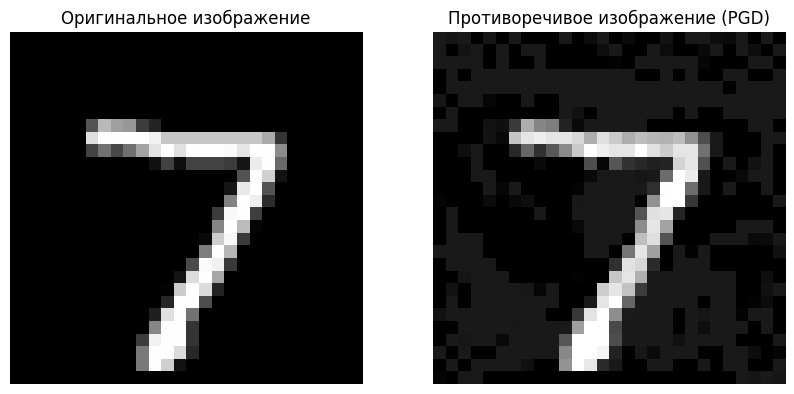

In [5]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод оригинального и противоречивого изображения
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

### 3. Оценка модели на противоречивых примерах

In [7]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0529 - loss: 7.5866
Accuracy on adversarial examples (PGD): 0.07150000333786011


### Вывод

Модель имеет высокую уязвимость к атакам типа PGD (Projected Gradient Descent). Изначальная точность в 97% свидетельствует о том, что модель хорошо справляется с тестовыми данными при нормальных условиях. Однако резкое снижение точности до 7% после применения атаки PGD показывает, что модель не устойчива к небольшим, но целенаправленным изменениям входных данных, которые могут быть эффективно использованы для введения в заблуждение модели.